In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import autograd as ag
from autograd import Tensor

## Automatic gradient computation
#### A computational graph perspective

In autograd, we can represent a mathematical expression into a computational graph. Suppose we have:
\begin{align}
c&=a+b\\
d&=b+1\\
e&=c*d
\end{align}

Then the constructed graph is

<img src="https://colah.github.io/posts/2015-08-Backprop/img/tree-def.png" width=300px/>

Letting $a=2$ and $b=1$, we then have

<img src="https://colah.github.io/posts/2015-08-Backprop/img/tree-eval.png" width=300px/>

Christopher Olah explained computational graph very well in [his blog](https://colah.github.io/posts/2015-08-Backprop/). Please refer to it for the details on the backpropagation step.

Now, to see how awesome autograd in action is, let's define a simple function:

$$y = a^2+3b$$

We are going to find the gradient of $a$ and $b$. It means, we need to obtain the derivatives of $y$ with respect to $a$ and $b$. Suppose we fix $a=2$ and $b=1$. Now let's convert the problem into code:

In [10]:
# a = 2
a = Tensor(2, requires_grad=True)

# b = 1
b = Tensor(1, requires_grad=True)

# y = a^2 + 3b
y = ag.square(a) + (3 * b)

The magic lies in this following code:

In [11]:
# Compute gradients of all tensors that require grad.
y.backward()

What is the gradient of $a$?
\begin{align}
\frac{dy}{da}&={2a}^{2-1}+0 \\ &=2(2) \\ &=4
\end{align}

Let's verify:

In [12]:
print('Gradient of a: ', a.grad)

Gradient of a:  4.0


Ok. We got desired result. Now, the gradient of $b$ is supposed to be
\begin{align}
\frac{dy}{db}&=0+3(1) \\ &=3
\end{align}

In [13]:
print('Gradient of b: ', b.grad)

Gradient of b:  3.0


Again, we got desired result.

## Practical example: neural network regressor

Autograd is cool. But what makes it even cooler is that we can address a more practical real-world problem, in a flexible manner, like how [those](http://keras.io/), [major](http://pytorch.org/), deep learning [frameworks](http://deeplearning.net/software/theano/) do. Autograd is the heart of the optimization of many (deep) neural network models. 

As we have (somewhat) implemented an autograd system, let's try to make a neural network to regress house price. We are going to use boston housing dataset. For the sake of simplicity, let's just use sklearn to load the dataset.

In [14]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

X, y = load_boston(return_X_y=True)
X = StandardScaler().fit_transform(X)

# Convert the feature and target into Tensors
X = Tensor(X)
y = Tensor(y.reshape(y.size, 1))

### Prepare the model parameters

In [15]:
n_samples, n_features = X.shape

# num. of hidden neuron
n_hidden = 50

# learning rate
lr = 0.0001

# input to hidden
W1 = Tensor(np.random.randn(n_features, n_hidden), requires_grad=True)
b1 = Tensor(np.zeros(n_hidden), requires_grad=True)

# hidden to output
W2 = Tensor(np.random.randn(n_hidden, 1), requires_grad=True)
b2 = Tensor(np.zeros(1), requires_grad=True)

def model_predict(X):
    return (X @ W1 + b1) @ W2 + b2

### Start the training
This following loop must be familiar: **gradient descent** algorithm

In [16]:
for i in range(200):
    # make a prediction
    y_pred = model_predict(X)

    # compute mean squared error loss, since we are dealing with regression
    loss = ag.mean(ag.square(y_pred - y))
    
    # print the loss
    if i % 10 == 0:
        print('loss at iteration %d: ' % (i), loss.data)

    # backpropagate the error
    loss.backward()

    # update parameters
    W1.data -= lr * W1.grad
    W2.data -= lr * W2.grad
    b1.data -= lr * b1.grad
    b2.data -= lr * b2.grad

    # zero the gradients of all nodes in the created graph
    # so the gradients do not accumulate
    loss.zero_grad()

loss at iteration 0:  1174.3051521699717
loss at iteration 10:  277.10082571862074
loss at iteration 20:  113.50977532279404
loss at iteration 30:  60.485596738370916
loss at iteration 40:  40.91443076850886
loss at iteration 50:  32.62423713691575
loss at iteration 60:  28.53354862116101
loss at iteration 70:  26.240934174518895
loss at iteration 80:  24.842365652931985
loss at iteration 90:  23.9443692110146
loss at iteration 100:  23.349158073156126
loss at iteration 110:  22.945845876569297
loss at iteration 120:  22.66775096126826
loss at iteration 130:  22.473020124981687
loss at iteration 140:  22.334657838740213
loss at iteration 150:  22.234917672120964
loss at iteration 160:  22.161962047776203
loss at iteration 170:  22.1077988679444
loss at iteration 180:  22.066974791248207
loss at iteration 190:  22.03573235634111


Note that the syntax and API calls are somewhat similar to those of pytorch. Basically we are doing the same thing. The difference is, pytorch has more optimization... And insanely smart team... And funding.

Now let's try to plot the result:

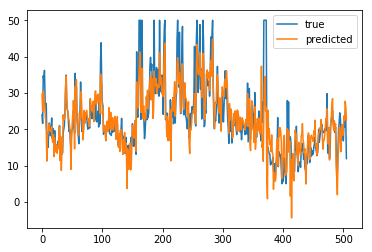

In [17]:
import matplotlib.pyplot as plt
plt.plot(y.data, label='true')
plt.plot(y_pred.data, label='predicted')
plt.legend()
plt.show()

Not a bad fit, eh. You can do exercise to implement more operations so we can add more extension to this mini framework, e.g., nonlinear activation functions, performing classification, etc.